In [32]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import time

from sklearn.cluster import KMeans
from tqdm.notebook import tqdm
from sklearn.metrics import silhouette_score


from langchain import LLMChain
import openai
from langchain.chat_models import ChatOpenAI
from langchain.embeddings.openai import OpenAIEmbeddings
from langchain.prompts.chat import (
    ChatPromptTemplate,
    SystemMessagePromptTemplate,
    HumanMessagePromptTemplate,
)
import warnings
warnings.filterwarnings("ignore")
pd.set_option('display.max_rows',500)
pd.set_option('display.max_columns',300)

In [2]:
from dotenv import load_dotenv, find_dotenv
load_dotenv(find_dotenv(), override=True)

True

In [5]:
df =pd.read_csv('Reviews.csv')
#df.head(3)
df=df[['Id', 'Score', 'Summary', 'Text']]
print(f"original size of the data set: {df.shape}")
# We are going to using only first 2000 reviews for this analysis
df = df.head(2000)
print(f"size of the final data set: {df.shape}")

original size of the data set: (568454, 4)
size of the final data set: (2000, 4)


## Embeddings

In [6]:
def get_embedding(text, model="text-embedding-ada-002"):
   text = text.replace("\n", " ")
   return openai.Embedding.create(input = [text], model=model)['data'][0]['embedding']

# df['ada_embedding'] = df.Text.apply(lambda x: get_embedding(x, model='text-embedding-ada-002'))
# df.to_csv('Reviews_with_embedding.csv', index=0) # save the file after embedding, which save some cost and time if we need to run it again

## Start from the saved file with embedded vector

In [7]:
df=pd.read_csv('Reviews_with_embedding.csv') 
df = df.head(2000) # make sure the size of the file. 

In [9]:
df.head(3)

,Id,Score,Summary,Text,ada_embedding
0,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,"[-0.0032094912603497505, -7.185583672253415e-0..."
1,2,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"[-0.011087631806731224, -0.010556526482105255,..."
2,3,4,"""Delight"" says it all",This is a confection that has been around a fe...,"[0.014519035816192627, 0.009235643781721592, -..."


In [9]:
# embedded vector (df.add_embedding) now a object type, which should be nan p.array type  

In [10]:
df['ada_embedding'] = df.ada_embedding.apply(eval).apply(np.array) # this will convert this column from string to np.array

In [ ]:
# Combining all arrys 

In [11]:
matrix = np.vstack(df.ada_embedding.values)
print(f"size of the matrix is:{matrix.shape}")
print(f"The dimention of vector embedding is {matrix.shape[1]}")

size of the matrix is:(2000, 1536)
The dimention of vector embedding is 1536


## Finding Optimal Number of Clusters 

In [16]:

def calculate_silhouette_scores(data_matrix, min_clusters=3, max_clusters=25):
    cluster_results_km = pd.DataFrame(columns=['k', 'score'])
    
    for k in tqdm(range(min_clusters, max_clusters + 1)):
        km_model = KMeans(n_clusters=k, init='k-means++', random_state=42)
        y = km_model.fit_predict(data_matrix)
        silhouette = silhouette_score(data_matrix, y)
        dic={'k': [k], 'score': [silhouette]}
        cluster_results_km=pd.concat([cluster_results_km, pd.DataFrame(dic)])    
    return cluster_results_km

def find_optimal_cluster(cluster_results):
    cluster_results = cluster_results.reset_index(drop=True)
    optimal_cluster = cluster_results['score'].idxmax()
    optimal_cluster = cluster_results['k'].iloc[optimal_cluster]
    return optimal_cluster

matrix = matrix

cluster_results_km = calculate_silhouette_scores(matrix)
num_cluster = find_optimal_cluster(cluster_results_km)

print("Optimal number of clusters:", num_cluster)
print(cluster_results_km.loc[cluster_results_km['k'] == num_cluster])

  0%|          | 0/23 [00:00<?, ?it/s]

Optimal number of clusters: 7
   k     score
0  7  0.062292


In [17]:
cluster_results_km=cluster_results_km.set_index('k')


<Axes: title={'center': 'silhouette scores vs cluster number'}, xlabel='k'>

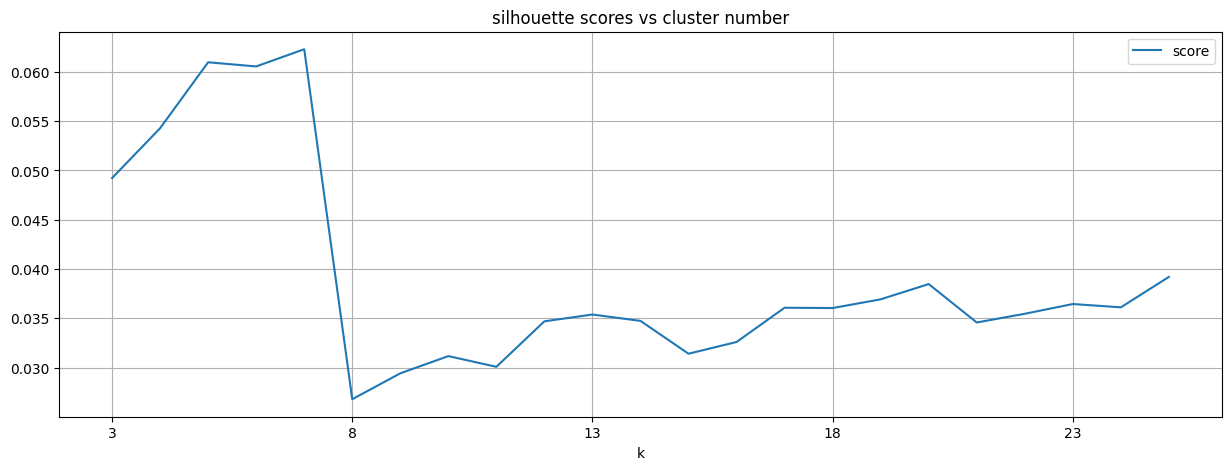

In [23]:
cluster_results_km.plot(title='silhouette scores vs cluster number', grid=True, figsize=(15, 5))

In [25]:
# Run the k-mean clusting with the optimal number of cluster
km_model = KMeans(n_clusters = num_cluster, init ='k-means++', random_state = 42)
y = km_model.fit_predict(matrix)
df['Cluster']=y

## Visualizing embedded vecotrs in 2-D space - TSNE

Text(0, 0.5, 'Axis 2')

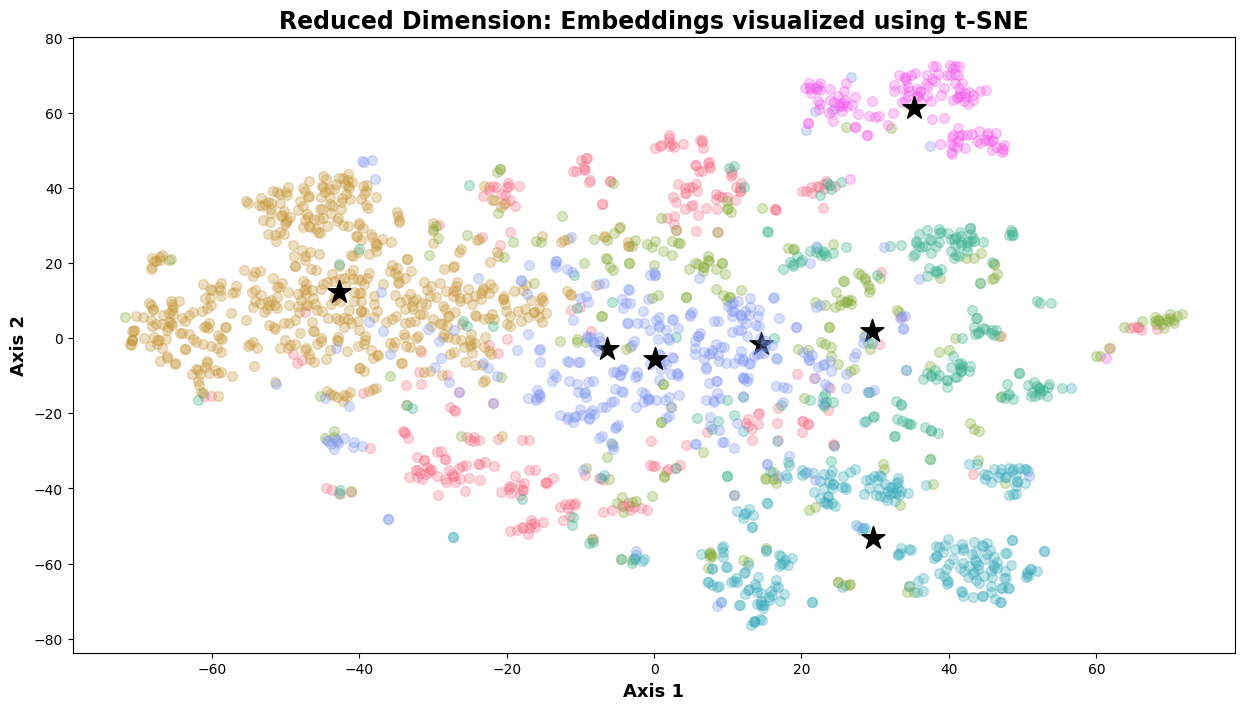

In [28]:
plt.rcParams['figure.figsize'] = (15, 8) 

tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims2 = tsne.fit_transform(matrix)

x = [x for x,y in vis_dims2]
y = [y for x,y in vis_dims2]

#palette = sns.color_palette("inferno", num_cluster).as_hex() 
palette = sns.color_palette("husl", num_cluster).as_hex()

for category, color in enumerate(palette):
    xs = np.array(x)[df.Cluster==category]
    ys = np.array(y)[df.Cluster==category]
    plt.scatter(xs, ys, color=color, alpha=0.3, s=50)

    avg_x = xs.mean()
    avg_y = ys.mean()
    
    plt.scatter(avg_x, avg_y, marker='*', color='black', s=300)
plt.title("Reduced Dimension: Embeddings visualized using t-SNE", size=17, fontweight="bold")
plt.xlabel('Axis 1',size=13, fontweight="bold")
plt.ylabel('Axis 2',size=13, fontweight="bold")

## Cluster Labelling/Topic Modeling

In [49]:
# if you don't take care the api calling rate, you will encounter the following error message:
# RateLimitError: Rate limit reached for default-gpt-3.5-turbo-16k in organization org-7d1yAjMgmG3lnmgY87cMEAVy on tokens per min. Limit: 180000 / min. Current: 177927 / min. Contact us through our help center at help.openai.com if you continue to have issues.

##### First Summarizing Texts

In [30]:
def call_openai_api(messages):
    return openai.ChatCompletion.create(
        model='gpt-3.5-turbo-16k',
        messages=messages,
        max_tokens=4096,
        temperature=1
    )

def summarize_text(transcript):
    system_prompt = "I would like for you to assume the role of a Life Coach"
    user_prompt = f"""Generate ten words summary of the text below.
    Text: {transcript}
    """
    
    messages = [
        {'role': 'system', 'content': system_prompt},
        {'role': 'user', 'content': user_prompt}
    ]
    
    response = call_openai_api(messages)
    summary = response['choices'][0]['message']['content']
    return summary


In [33]:
## Be mindfull that this step takes sometime

In [35]:
df1=pd.DataFrame()
for i in range(20):
    init = i*100
    final = (i+1)*100
    dk = df.iloc[init:final]
    print(i, init, final)
    dk['summary_openai'] = dk['Text'].map(lambda x: summarize_text(x))
    df1 = pd.concat([df1, dk])
    time.sleep(60)
    del dk

In [36]:
df1.head(2)

,Id,Score,Summary,Text,ada_embedding,Cluster,summary_openai
0,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,"[-0.0032094912603497505, -7.185583672253415e-0...",6,Positive review of Vitality canned dog food fo...
1,2,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"[-0.011087631806731224, -0.010556526482105255,...",2,Error in product labeling: small unsalted pean...


## Text Labelling

In [66]:
def get_prompt():
    system_template = "You are a market analysis and know all reviews from Amazon. You're helping me write a concise topic from many reviews."
    human_template = "Using the following reviews, write a topic title that summarizes them.\n\nREVIEWS:{reviews}\n\nTOPIC TITLE:"

    return ChatPromptTemplate(
        messages=[
            SystemMessagePromptTemplate.from_template(system_template),
            HumanMessagePromptTemplate.from_template(human_template),
        ],
        input_variables=["reviews"],
    )

for c in df1.Cluster.unique():
    chain = LLMChain(
        llm=ChatOpenAI(temperature=0, model_name="gpt-3.5-turbo-16k"), prompt=get_prompt(), verbose=False
    )
    review_str = "\n".join(
        [
            f"{review['summary_openai']}\n"
            for review in df1.query(f"Cluster == {c}").to_dict(orient="records")
        ]
    )
    result = chain.run(
        {
            "reviews": review_str,
        }
    )
    df1.loc[df1.Cluster == c, "review_topic"] = result

In [67]:
df1.head(2)

,Id,Score,Summary,Text,ada_embedding,Cluster,summary_openai,review_topic
0,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,"[-0.0032094912603497505, -7.185583672253415e-0...",6,Positive review of Vitality canned dog food fo...,The Impact of High-Quality Dog and Cat Food on...
1,2,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"[-0.011087631806731224, -0.010556526482105255,...",2,Product mislabeled: small unsalted peanuts ins...,Assessing Disappointing Food Products and Pack...


In [146]:
df1['review_topic'].unique()

array(['The Impact of High-Quality Dog and Cat Food on Health and Satisfaction',
       'Assessing Disappointing Food Products and Packaging on Amazon',
       'Delicious Treats and Snacks: Reviews and Recommendations',
       'Exploring the World of Beverages: Coffee, Tea, Sweeteners, and More',
       'Delicious and Flavorful Food Finds on Amazon: Hot Sauce, Pickled Asparagus, Ramen, Soy Sauce, Caviar, Pasta, and More',
       "Convenient and Nutritious Breakfast Options: Reviews of McCann's Instant Oatmeal, Mueslix Cereal, and Earth's Best Baby Food",
       'Popchips: A Tasty and Healthier Alternative to Regular Potato Chips'],
      dtype=object)

In [147]:
df1[df1['review_topic']=='Delicious Treats and Snacks: Reviews and Recommendations'].head(2)

,Id,Score,Summary,Text,ada_embedding,Cluster,summary_openai,review_topic
2,3,4,"""Delight"" says it all",This is a confection that has been around a fe...,"[0.014519035816192627, 0.009235643781721592, -...",5,"Citrus gelatin with nuts, coated in sugar, hea...",Delicious Treats and Snacks: Reviews and Recom...
4,5,5,Great taffy,Great taffy at a great price. There was a wid...,"[-0.015514752827584743, -0.008861816488206387,...",5,Delicious and affordable taffy with quick deli...,Delicious Treats and Snacks: Reviews and Recom...


In [149]:
df1['review_topic'].unique()

array(['The Impact of High-Quality Dog and Cat Food on Health and Satisfaction',
       'Assessing Disappointing Food Products and Packaging on Amazon',
       'Delicious Treats and Snacks: Reviews and Recommendations',
       'Exploring the World of Beverages: Coffee, Tea, Sweeteners, and More',
       'Delicious and Flavorful Food Finds on Amazon: Hot Sauce, Pickled Asparagus, Ramen, Soy Sauce, Caviar, Pasta, and More',
       "Convenient and Nutritious Breakfast Options: Reviews of McCann's Instant Oatmeal, Mueslix Cereal, and Earth's Best Baby Food",
       'Popchips: A Tasty and Healthier Alternative to Regular Potato Chips'],
      dtype=object)

In [158]:
pd.set_option('display.max_colwidth', 80)


In [38]:
#df1[df1['review_topic']=='The Impact of High-Quality Dog and Cat Food on Health and Satisfaction'][[['summary_openai', 'review_topic']].head(10)